In [1]:
from __future__ import print_function
from datahandling import access_db, get_equip_names, get_dtype_names
from tinydb import Query
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from time import time
from pandas import DataFrame
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
db_X = access_db(3, True)

In [3]:
sv_db = access_db(0, True)

In [4]:
# db_X.purge()

In [5]:
Q = Query()

In [6]:
ingredients = ['PVC', 'filler', 'FR', 'stabiliser', 'DINP', 'LDH', 'spherical_filler']

In [7]:
equip_names = get_equip_names(sv_db)
equip_names

[u'colour', u'LOI', u'MCC', u'thermomat', u'tensile', u'rheomix', u'ConeCal']

In [8]:
sv_db.remove((Q.sample_number == 35))

[]

Populate X from single value database and store in new db

In [9]:
X = []
tm = time()
d_types_skip = ['epsilon_break_%', 
                'epsilon_max_%', 
                'sigma_break_MPa', 
                'sigma_max_MPa', 
                'E_t_MPa',
                'int_of_abs_err'
               ]

if not db_X.all():
    d_type_descr = []
    for sample_no in range(53):
        sample_no += 1
        
        if sample_no == 35:
            continue
        
        data_p_sample = []

        for ing in ingredients:
            entry = sv_db.search((Q.sample_number == sample_no) &
                                 (Q.ingredient == ing))
            val = entry[0]['value']
            data_p_sample.append(val)
            
            if sample_no == 1:
                d_type_descr.append('MassFrac ' + ing) 

        for en in equip_names:
            d_type_names = get_dtype_names(sv_db, en)
            d_type_names = [i for i in d_type_names if i not in d_types_skip]
            for dtn in d_type_names:
                entry = sv_db.search((Q.sample_number == sample_no) &
                                     (Q.equipment_name == en) &
                                     (Q.data_type == dtn))

                if entry:
                    val = entry[0]['value']
                else:
                    val = None

                data_p_sample.append(val)
                
                if sample_no == 1:
                    d_type_descr.append(en + ' ' + dtn)

        X.append(data_p_sample)
    
    entry = {'X': X,
             'd_type_descr': d_type_descr}
    db_X.insert(entry)

req_time = time() - tm
print(req_time)

0.0


Database has missing values, missing values can either be replaced by mean or the incomplete rows are excluded from X

In [56]:
X = db_X.all()[0]['X']
impute = False
if impute:
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imp.fit(X)
    X = imp.transform(X)
else:
    # Removing all incomplete samples
    X = [sample for sample in X if None not in sample]

Do PCA

In [57]:
X_std = StandardScaler().fit_transform(X)

In [58]:
len(X_std[0])

41

In [59]:
my_pca = PCA(n_components=41)

In [60]:
my_pca.fit(X_std)

PCA(copy=True, n_components=41, whiten=False)

Analyse PCA results by looking at principal components with highest explained variance

In [61]:
comp = my_pca.components_

In [62]:
my_pca.explained_variance_ratio_

array([  2.52815680e-01,   1.88756881e-01,   1.48023254e-01,
         1.10701840e-01,   7.25849767e-02,   5.66301599e-02,
         3.59782139e-02,   3.27832836e-02,   2.84664756e-02,
         2.33077626e-02,   2.12459101e-02,   1.17255629e-02,
         7.07183708e-03,   4.90658487e-03,   2.75773456e-03,
         2.24384375e-03,   4.68558451e-33])

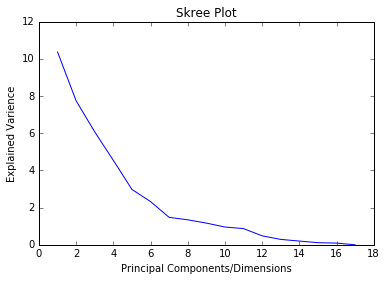

In [63]:
exp_var = my_pca.explained_variance_
plt.plot([i + 1 for i in range(len(exp_var))], exp_var)
plt.title('Skree Plot')
plt.xlabel('Principal Components/Dimensions')
plt.ylabel('Explained Varience')

In [64]:
descr = db_X.all()[0]['d_type_descr']

In [65]:
comp = [list(c) for c in comp]

In [66]:
d = [descr] + comp

In [67]:
df = DataFrame(data=d).T

In [69]:
prin_comp = 1
top = 5
sort_df = df.reindex(df[prin_comp].abs().sort_values(ascending=False).index)
clipped_df = sort_df.head(n=top)[[0, prin_comp]]
clipped_df

,0,1
16,MCC t_HR_peak_1_kJpg,-0.296511
4,MassFrac DINP,-0.289211
23,tensile epsilon_break_%_mean,-0.281056
26,tensile epsilon_max_%_mean,-0.278876
8,LOI Final,0.260714


In [70]:
names = clipped_df[0].tolist()

In [71]:
names

[u'MCC t_HR_peak_1_kJpg',
 u'MassFrac DINP',
 u'tensile epsilon_break_%_mean',
 u'tensile epsilon_max_%_mean',
 u'LOI Final']

In [72]:
df_2 = DataFrame(data=X_std, columns=descr)[names]

[[None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None]]

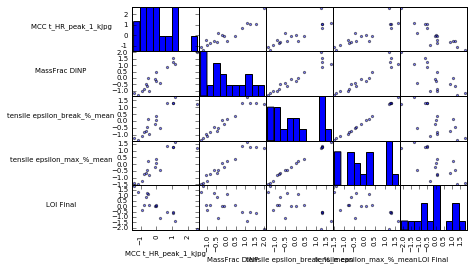

In [73]:
Axes = scatter_matrix(df_2)#, diagonal='kde')
n = len(df_2.columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = Axes[x, y]
        # to make x axis name vertical  
#         ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

size = 7
[plt.setp(item.yaxis.get_majorticklabels(), 'size', size) for item in Axes.ravel()]
[plt.setp(item.xaxis.get_majorticklabels(), 'size', size) for item in Axes.ravel()]
[plt.setp(item.xaxis.get_label(), 'size', size) for item in Axes.ravel()]
[plt.setp(item.yaxis.get_label(), 'size', size) for item in Axes.ravel()]